# Store Item Demand Forecasting Challenge
#### Predict 3 months of item sales at different stores

### 1) Definição do problema
&emsp;&emsp;Para comerciantes varejistas e atacadistas, realizar a projeção de vendas dos seus produtos e também estimar as vendas de seus concorrentes é uma tarefa comum. É importante para que os gestores das empresas possam tomar decisões a respeito de quais produtos a empresa deve ter mais em estoque, os melhores produtos para trabalhar o marketing, os produtos que devem ser deixados de lado, quais produtos colocar em promoções, além de várias outras medidas a serem tomadas a fim de obter um maior lucro para a empresa. <br/>
&emsp;&emsp;Essa missão normalmente é designada aos gestores que confiam em suas análises e vivências para tentar realizar a estimativa de vendas. O intuito deste projeto é realizar um modelo capaz de prever as vendas futuras com base nos dados históricos utilizando técnicas estatísticas, machine learning e deep learning. Com isso, fornecer mais uma ferramenta para auxilizar os gestores em suas tomadas de decisões sem necessariamente confiar em seus "feelings" do negócio, e sim em um modelo matemática capaz de explicar o que vai acontecer baseado nos eventos que já ocorreram.

#### 1.1) Objetivos da competição
&emsp;&emsp;Esta competição é fornecida como uma forma de explorar diferentes técnicas de séries temporais em um conjunto de dados relativamente simples e limpo. O analista recebe 5 anos de dados de vendas de itens da loja e é solicitado a prever 3 meses de vendas para 50 itens diferentes em 10 lojas diferentes.<br/>
&emsp;&emsp;Qual é a melhor maneira de lidar com a sazonalidade? As lojas devem ser modeladas separadamente ou você pode agrupá-las? O aprendizado profundo funciona melhor que o ARIMA? Qualquer um pode vencer o xgboost?</br>
&emsp;&emsp;Esta é uma grande competição para explorar diferentes modelos e melhorar as habilidades com previsão. Aqui você encontra o link para a competição: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview



#### 1.2) Algoritmos utilizados
 **Explicar melhor aqui**

#### 1.3) Import das bibliotecas e carregando os dados de treino e teste
O primeiro passo será importar todas as bibliotecas que iremos utilizar. **Explicar melhor aqui**

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objs as go
from scipy.spatial.distance import euclidean #used for fdt
import fastdtw as fdt #fast dynamic time warping
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
#from pyramid.arima import auto_arima #auto ARIMA model (pip install pyramid-arima)
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

In [72]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

### 2) Análise exploratória dos dados

Vamos começar fazendo uma análise exploratória dos dados, para ter uma ideia de quantas colunas os dados possuem, quantos registros, agrupamentos, se há dados missing/nulos, além de outras análises.<br/>
Como primeiro passo, vamos exibir quantos registros e quantas colunas há em ambos os datasets, o de treino e o de teste.

##### 2.1) Visão Geral

In [74]:
print('Shape Treino: {}'.format(df_train.shape))
print('Shape Teste: {}'.format(df_test.shape))

Shape Treino: (913000, 4)
Shape Teste: (45000, 4)


In [75]:
df_train.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [76]:
df_test.head(5)

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


Analisando pelo cabeçalho vemos que o dataset de treino possui quantro colunas:
* **date**: Data que o item foi vendido;
* **store**: Id da loja;
* **item**: Id do item;
* **sales**: Quantidade de vendas (Nossa variável target)

E no conjunto do teste, não temos a quantidade de sales, porém temos um atributo **id** do registro.

In [77]:
df_train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


Aqui temos algumas informações interessantes. A média de vendas é de 52.25, enquanto que a mediana é de 47. Isso significa que a presença de outliers não está impactando o resultado, dado que a amplitude da variável target é de : 0 vendas a 231 vendas, enquanto que a diferença entre média e mediana é de apenas 5.

In [78]:
print('Dados nulos conjunto de treino')
print(df_train.isnull().sum())
print('\nDados nulos conjunto de testes')
print(df_test.isnull().sum())

Dados nulos conjunto de treino
date     0
store    0
item     0
sales    0
dtype: int64

Dados nulos conjunto de testes
id       0
date     0
store    0
item     0
dtype: int64


Vamos dividir as datas nos nossos dataset, assim vamos ter mais possibilidades de análises.

In [79]:
def expand_df(df):
    data = df.copy()
    data['date'] = pd.to_datetime(data['date'])
    data['day'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['dayofweek'] = data['date'].dt.dayofweek
    return data

df_train = expand_df(df_train)
df_test = expand_df(df_test)

In [80]:
df_train.head()

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5


Esse conjunto de dados está bem limpo, não há registros missing/nulos, portanto não precisaremos realizar esta etapa no pré processamento dos dados.

In [81]:
df_sales = df_train.copy()
df_sales['bins_sales'] = pd.cut(df_sales['sales'], [-1, 50, 100, 150, 200, 250, 300])
total_sales = df_sales.shape[0]
df_percent = pd.DataFrame(pd.value_counts(df_sales['bins_sales']).apply(lambda s: round((s/total_sales)*100, 2)))
df_percent.reset_index(inplace=True)
df_percent.columns = ['Grupo', 'Porcentagem']
df_percent

,Grupo,Porcentagem
0,"(-1, 50]",54.59
1,"(50, 100]",38.39
2,"(100, 150]",6.71
3,"(150, 200]",0.31
4,"(200, 250]",0.00
5,"(250, 300]",0.00


Aqui geramos um dataset temporário para agrupar as vendas por grupos e exibir a porcentagem correspondente a cada grupo:
* 0-50 vendas: 54.59% dos dados estão agrupados neste grupo.
* 50-100 vendas: 38.39% dos dados estão agrupados aqui.
* 100-250 vendas: Somente 7% dos dados compõem o restante dos grupos. <br/>

Isso implica que os modelos que iremos desenvolver deverão lidar com a assimetria (skewness) dos dados.

##### 2.2) Métrica de Avaliação
##### 2.2.2) Stationarity Test (Dickey Fuller)
Os dados da série temporal devem ser estacionários antes de aplicar um modelo ARIMA. Estacionário significa que a média, o desvio padrão e a variância não mudam ao longo do tempo. A função abaixo testa se uma Série Temporal é estacionária ou não.

In [82]:
def Fuller(TimeSeries):
    """Fornece resultados de teste mais completos para séries temporais"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))


##### 2.3) Variação de vendas entre as lojas
Agora vamos observar como as vendas variam entre cada loja e obter uma visão geral da distribuição de vendas em todos os dados.

In [83]:
df_train.head()

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5


In [84]:
# Vamos entender como as vendas estão distribuídas por lojas, vamos realizar o pivot dos dados e aplicar a função média de vendas por item.
df_store = df_train.copy()
df_sales_pivoted = pd.pivot_table(df_store, index='store', values=['sales'], columns='item', aggfunc=np.sum)
# Dataframe com Pivot
display(df_sales_pivoted)

sales                                                               \
item      1       2      3      4      5       6       7       8       9    
store                                                                       
1      36468   97050  60638  36440  30335   96889   96383  126856   84918   
2      51445  137528  85808  51557  42985  136850  137057  180939  119563   
3      45778  121985  76274  45862  38086  122355  121699  159807  106797   
4      41886  112692  70389  42156  35653  111880  112528  147577   98684   
5      30566   81236  50828  30634  25722   81375   81322  106941   70917   
6      30527   81319  50783  30593  25369   81264   81438  106612   72054   
7      27681   74351  46620  28044  23252   74325   74336   98100   65557   
8      49272  130845  82309  49208  40953  131396  130980  172486  115391   
9      42593  112833  70365  42272  35191  112139  112869  148431   98797   
10     45168  119725  75073  45141  37684  119808  120165  157359  105701   

               ...                                                      \
item       10  ...     41     42      43     44      45      46     47   
store          ...                                                       
1      121163  ...  36525  60451   84439  48561  132788   96495  36181   
2      171822  ...  51255  86494  120124  68997  188774  137351  51471   
3      152266  ...  45630  76322  106269  60963  167720  121882  45870   
4      140689  ...  42305  70374   98638  56519  154639  112153  42207   
5      101361  ...  30733  50636   71512  40930  112166   81686  30493   
6      101462  ...  30325  50933   71277  40761  111647   81330  30510   
7       93412  ...  28251  46446   64688  37335  102084   74553  28265   
8      164008  ...  49368  82433  115002  66091  180667  131481  49576   
9      140794  ...  42347  70563   98883  56548  155381  113232  42004   
10     150156  ...  45020  75273  105803  60106  165601  120601  45204   

                              
item       48     49      50  
store                         
1       84993  48319  108360  
2      120568  68862  154520  
3      107188  60732  136874  
4       98176  56315  125851  
5       71728  40851   91883  
6       71310  40503   92243  
7       65050  37262   83674  
8      114558  65800  147855  
9       98562  56702  126557  
10     105570  60317  135192  

[10 rows x 50 columns]

In [85]:
for i in range(len(df_sales_pivoted.index)):
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=np.arange(0, len(df_sales_pivoted.values[i])) + 1,
        y=df_sales_pivoted.values[i],
    ))

    fig.update_layout(
        title='<span>Vendas da loja {}</span>'.format(str(i)), 
        autosize=False,
        width=1200,
        height=300,
        yaxis=dict(title='<span>Quantidade</span>'),
        xaxis=dict(title='<span>Itens</span>')
        )

    fig.show()


Podemos perceber que a proporção de produtos vendidos para cada loja segue um padrão, por exemplo o produto 1 vende menos que o produto 2 em todas as lojas e assim sucessivamente.

In [86]:
sr_sales = df_sales.groupby('store')['sales'].sum()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=sr_sales.index.astype(str), 
    y=sr_sales.values,
    text=sr_sales.values,
))

fig.update_layout(
        title='<span>Total de vendas por loja</span>', 
        autosize=False,
        width=1000,
        height=500,
        yaxis=dict(title='<span>Quantidade</span>'),
        xaxis=dict(title='<span>Loja</span>')
    )

fig.show()

Com os dados que temos podemos notar que a loja 2 é a campeã em vendas, seguida da loja 8, enquanto que as lojas 5, 6 e 7 estão bem atrás na quantidade de itens vendidos.

In [87]:
df_store = df_train.copy()
df_storeMean = pd.pivot_table(df_store, index='store', values=['sales'], columns='item', aggfunc=np.mean)
df_storeMean['avg_sale'] = df_storeMean.apply(lambda r: r.mean(), axis=1)
df_storeMean.head(10)

sales                                                         \
item           1          2          3          4          5          6   
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                   ...                        \
item           7          8          9         10  ...         42         43   
store                                              ...                         
1      52.783680  69.472070  46.504929  66.354326  ...  33.105696  46.242607   
2      75.058598  99.090361  65.478094  94.097481  ...  47.368018  65.785323   
3      66.647864  87.517525  58.486857  83.387733  ...  41.797371  58.197700   
4      61.625411  80.819825  54.043812  77.047645  ...  38.539978  54.018620   
5      44.535597  58.565717  38.837349  55.509858  ...  27.730559  39.163198   
6      44.599124  58.385542  39.460022  55.565170  ...  27.893209  39.034502   
7      40.709748  53.723987  35.901972  51.156627  ...  25.435926  35.426068   
8      71.730559  94.461117  63.193319  89.818182  ...  45.144031  62.980285   
9      61.812158  81.287514  54.105696  77.105148  ...  38.643483  54.152793   
10     65.807777  86.176889  57.886637  82.232202  ...  41.222892  57.942497   

                                                                          \
item          44          45         46         47         48         49   
store                                                                      
1      26.594195   72.720701  52.845016  19.814348  46.546002  26.461665   
2      37.785871  103.381161  75.219606  28.187842  66.028478  37.711939   
3      33.386090   91.851041  66.748083  25.120482  58.700986  33.259584   
4      30.952355   84.687295  61.420044  23.114458  53.765608  30.840635   
5      22.415115   61.427163  44.734940  16.699343  39.281490  22.371851   
6      22.322563   61.142935  44.539978  16.708653  39.052574  22.181271   
7      20.446331   55.905805  40.828587  15.479189  35.624315  20.406353   
8      36.194414   98.941402  72.004929  27.150055  62.737130  36.035049   
9      30.968237   85.093647  62.010953  23.003286  53.976999  31.052574   
10     32.916758   90.690581  66.046550  24.755750  57.814896  33.032311   

                   avg_sale  
item          50             
store                        
1      59.342826  47.268379  
2      84.622125  67.033165  
3      74.958379  59.530602  
4      68.921687  54.902946  
5      50.319277  39.770164  
6      50.516429  39.733516  
7      45.823658  36.363735  
8      80.972070  64.142048  
9      69.308324  55.049025  
10     74.037240  58.709288  

[10 rows x 51 columns]

In [88]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df_storeMean['avg_sale'].values,
    mode='markers',
    marker=dict(
        size = df_storeMean['avg_sale'].values,
        color = df_storeMean['avg_sale'].values,
        colorscale = 'Viridis',
        showscale = True

    ),
    text = df_storeMean.index.values
))

fig.update_layout(
        title='<span>Média de vendas por loja</span>', 
        autosize=False,
        width=700,
        height=500,
        yaxis=dict(title='<span>Média de vendas</span>'),
        xaxis=dict(title='<span>Lojas</span>')
    )

fig.show()

Outra forma de visualizar a informação que tinhamos visto anteriormente. O gráfico só confirma que as lojas 2 e 8 são as que mais vendem enquanto que as lojas 4, 5 e 6 são as que estão vendendo menos.

##### 2.4) Variação de vendas entre os itens

In [89]:
sr_sales = df_sales.groupby('item')['sales'].sum()
sr_sales.sort_values(ascending=False, inplace=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=sr_sales.index.astype(str)[0:15], 
    y=sr_sales.values[0:15],
    text=sr_sales.values[0:15],
))

fig.update_layout(
        title='<span>Total de vendas por item</span>', 
        autosize=False,
        width=1300,
        height=500,
        yaxis=dict(title='<span>Quantidade</span>'),
        xaxis=dict(title='<span>Item</span>')
    )

fig.show()

Observamos que os dez produtos mais vendidos são: 15, 28, 13, 18, 25, 45, 38, 22, 36 e 8, respectivamente.

##### 2.5) Variabilidade por ano
Vamos ver como os itens e lojas crescem ao longo dos anos.

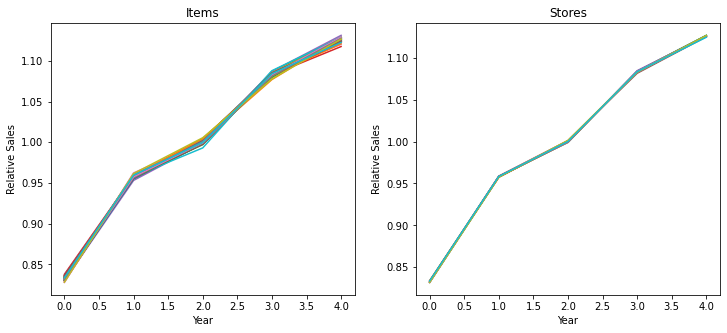

In [90]:
dfAggYearItem = pd.pivot_table(df_train, index='year', columns='item', values='sales', aggfunc=np.mean).values
dfAggYearStore = pd.pivot_table(df_train, index='year', columns='store', values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(dfAggYearItem / dfAggYearItem.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(dfAggYearStore / dfAggYearStore.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()

##### 2.5) Variabilidade por meses

Vejamos como as vendas dos itens por loja se comportam no decorrer dos meses. 

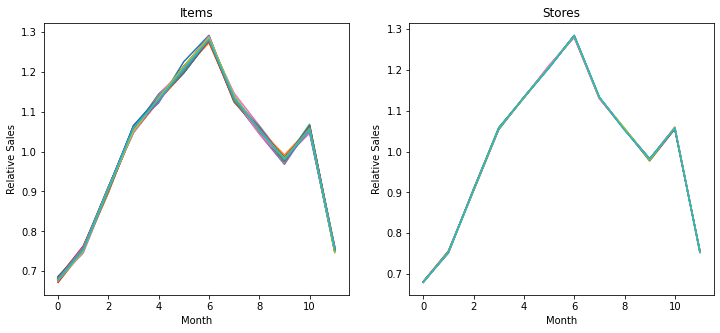

In [91]:
dfAggMonthItem = pd.pivot_table(df_train, index='month', columns='item', values='sales', aggfunc=np.mean).values
dfAggMonthStore = pd.pivot_table(df_train, index='month', columns='store', values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(dfAggMonthItem / dfAggMonthItem.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(dfAggMonthStore / dfAggMonthStore.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()

##### 2.7) Variabilidade por dia da semana

Assim como os dois tópicos anteriores, agora é hora de ver como as vendas por lojas se comportam nos dias da semana. Como as vendas variam por dia da semana? Existe sazonalidade também? As lojas compartilham as mesmas tendências?

In [92]:
df_day = df_train.copy()
df_day.set_index(pd.to_datetime(df_day['date']), inplace=True) 
df_day.drop(columns='date', inplace=True)
df_day['Day'] = df_day.index.to_series().dt.day_name()

df_day.head()

,store,item,sales,day,month,year,dayofweek,Day
date,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,Tuesday
2013-01-02,1,1,11,2,1,2013,2,Wednesday
2013-01-03,1,1,14,3,1,2013,3,Thursday
2013-01-04,1,1,13,4,1,2013,4,Friday
2013-01-05,1,1,10,5,1,2013,5,Saturday


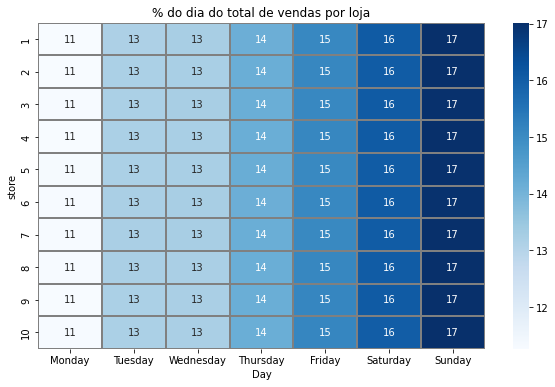

In [93]:
df_dow_store = df_day.groupby(['store','Day']).sum()['sales'].groupby(level=0).apply(lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday']]

plt.rcParams["figure.figsize"] = [10,6]

sns.heatmap(df_dow_store, cmap='Blues', linewidths=0.01, linecolor='gray', annot=True).set_title('% do dia do total de vendas por loja')
plt.show()

O gráfico acima mostra o % mix de vendas da loja por dia. Podemos ver que as lojas são muito parecidas em quais dias são populares.

Vamos fazer o mesmo para os itens.

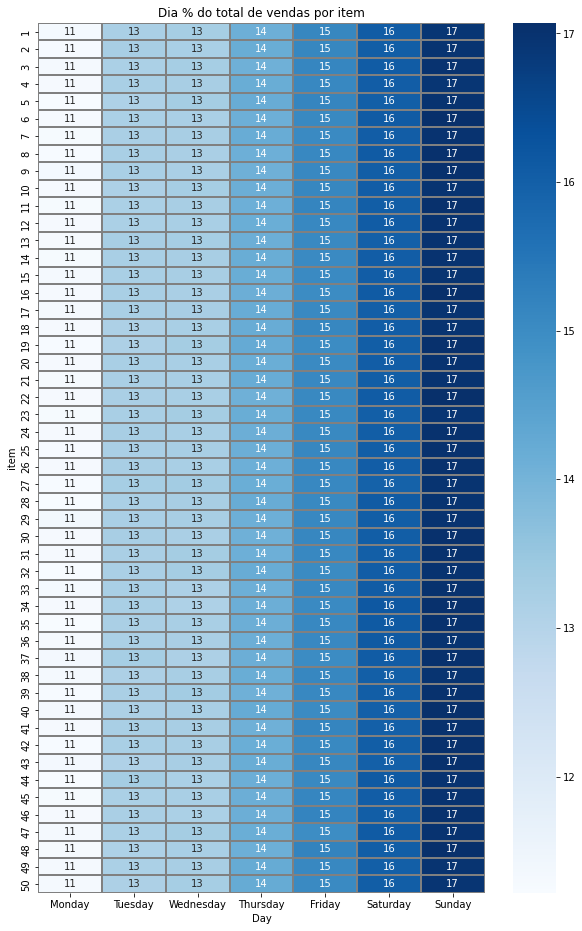

In [94]:
df_dow_item = df_day.groupby(['item','Day']).sum()['sales'].groupby(level=0).apply( lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday', 
    'Tuesday', 
    'Wednesday',
    'Thursday', 
    'Friday', 
    'Saturday', 
    'Sunday']]

plt.rcParams["figure.figsize"] = [10,16]
sns.heatmap(df_dow_item, cmap='Blues', linewidths=0.01, linecolor='gray', annot=True).set_title('Dia % do total de vendas por item')
plt.show()

Esse gráfico nos diz que as vendas de cada item são quase idênticas em termos de quais dias são mais populares.

Agora vamos ver se cada dia geralmente tende a mesma que a semana total.

In [95]:
df_dow = pd.DataFrame(df_day.groupby(['date','Day']).sum()['sales']).unstack()['sales'].loc[:,['Monday', 
    'Tuesday', 
    'Wednesday', 
    'Thursday', 
    'Friday', 
    'Saturday', 
    'Sunday']]
df_dow = df_dow.resample('7D',label='left').sum()
df_dow.sort_index(inplace = True)

In [96]:
fig = go.Figure()

for column in df_dow:
    fig.add_trace(go.Scatter(
        x=df_dow.index,
        y=df_dow[column],
        name=column
    ))

fig.update_layout(
    title='<span>Vendas por dias da semana</span>', 
    autosize=False,
    width=1250,
    height=400,
    xaxis=dict(title='<span>Período</span>'),
    yaxis=dict(title='<span>Quantidade de vendas</span>')
)
fig.show()

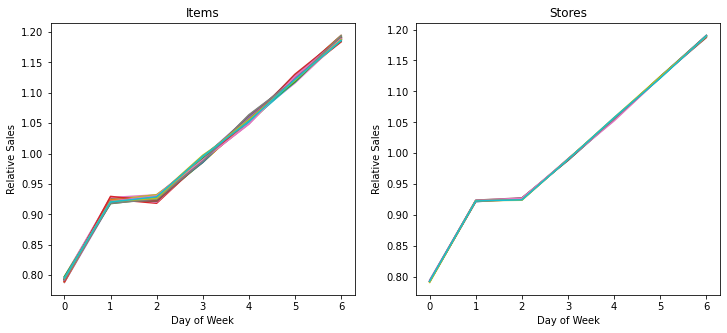

In [97]:
dfAggDowItem = pd.pivot_table(df_train, index='dayofweek', columns='item', values='sales', aggfunc=np.mean).values
dfAggDowStore = pd.pivot_table(df_train, index='dayofweek', columns='store', values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(dfAggDowItem / dfAggDowItem.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(dfAggDowStore / dfAggDowStore.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

**Conclusão do dia da semana**<br/>
O dia da semana afeta as vendas, no entanto, todas as lojas e itens têm distribuições semelhantes. As tendências do dia da semana seguem a tendência semanal geral. são mais populares. O dia geralmente tende a mesma que a semana total.

##### 2.8) Os padrões são degenerados?

Esses padrões são degenerados?
Esta é uma importante questão. A não verificação de degenerações nos dados pode levar à perda de tendências importantes em conjuntos de dados complexos. Por exemplo, ao analisar os padrões mensais, calculamos a média de todos os dias do mês, anos e itens ou lojas. Mas e se as vendas tiverem uma dependência multidimensional de dois desses parâmetros que não são facilmente separáveis? Portanto, sempre verifique se há degenerações nos dados!


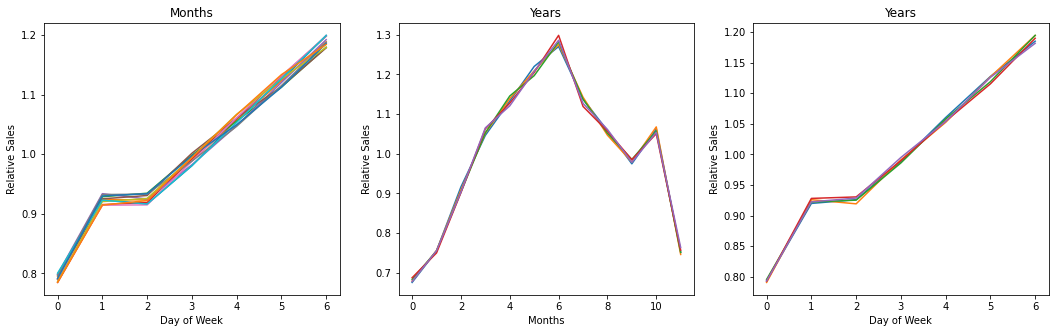

In [98]:
dfAggDowMonth = pd.pivot_table(df_train, index='dayofweek', columns='month', values='sales', aggfunc=np.mean).values
dfAggMonthYear = pd.pivot_table(df_train, index='month', columns='year', values='sales', aggfunc=np.mean).values
dfAggDowYear = pd.pivot_table(df_train, index='dayofweek', columns='year', values='sales', aggfunc=np.mean).values

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(dfAggDowMonth / dfAggDowMonth.mean(0)[np.newaxis])
plt.title("Months")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(132)
plt.plot(dfAggMonthYear / dfAggMonthYear.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Months")
plt.ylabel("Relative Sales")
plt.subplot(133)
plt.plot(dfAggDowYear / dfAggDowYear.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

Neste caso, no entanto, não parece haver nenhuma degeneração sorrateira. Podemos efetivamente tratar o "mês", "ano", "dia da semana", "item" e "loja" como modificadores completamente independentes da previsão de vendas. Isso leva a um modelo de previsão muito simples.

"Vendas relativas" nos gráficos acima são as vendas relativas à média. Uma vez que existem padrões muito regulares nas tendências "mês", "dia da semana" e "ano". Tudo o que temos a fazer é simplesmente memorizar essas tendências e aplicá-las às nossas previsões, multiplicando-as pelas vendas médias esperadas. Obtemos as vendas médias esperadas de um item em uma loja a partir dos números históricos no conjunto de treinamento.

##### 2.9) E a relação item-loja
Vimos como as lojas e os itens tendem por si só, mas algumas lojas vendem mais de um item? Ou seja: as lojas têm o mesmo mix de vendas? Os itens são vendidos uniformemente (em porcentagem) em todas as lojas?

Abaixo está um gráfico para a distribuição percentual das vendas de cada item nas lojas (cada linha soma 100%). Como podemos ver, é muito uniforme. A vantagem aqui é que os itens são vendidos uniformemente nas lojas.

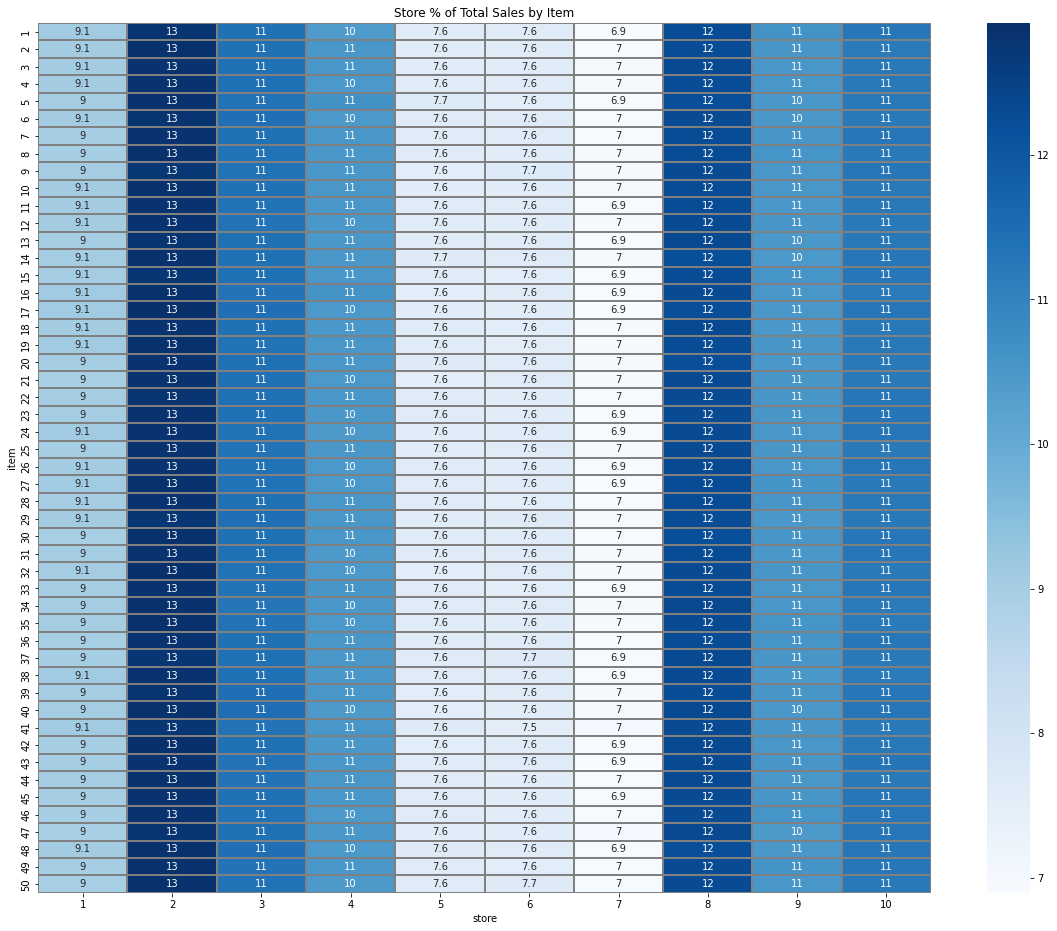

In [99]:
plt.rcParams["figure.figsize"] = [20,16]
df_store_item = df_train.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(df_store_item, cmap='Blues', linewidths=0.01, linecolor='gray', annot=True).set_title('Store % of Total Sales by Item')
plt.show()

Agora, para confirmar, vamos ver a % de distribuição das vendas de cada loja nos diferentes itens (cada linha soma 100%).

Podemos ver que cada loja vendeu aproximadamente a mesma porcentagem de cada item.

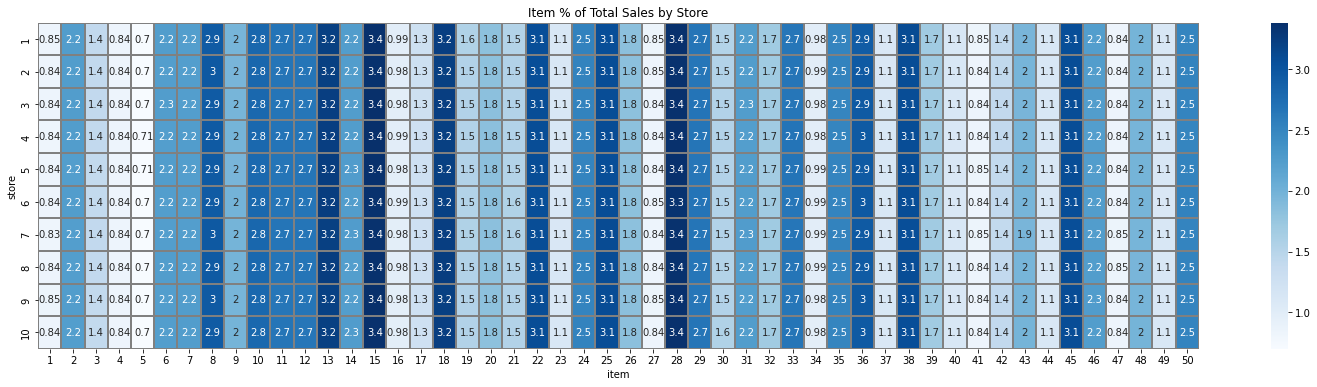

In [100]:
plt.rcParams["figure.figsize"] = [26,6]
df_item_store = df_train.groupby(by=['store','item']).sum()['sales'].groupby(level=0).apply(lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(df_item_store , cmap='Blues', linewidths=0.01, linecolor='gray', annot=True).set_title('Item % of Total Sales by Store')
plt.show()

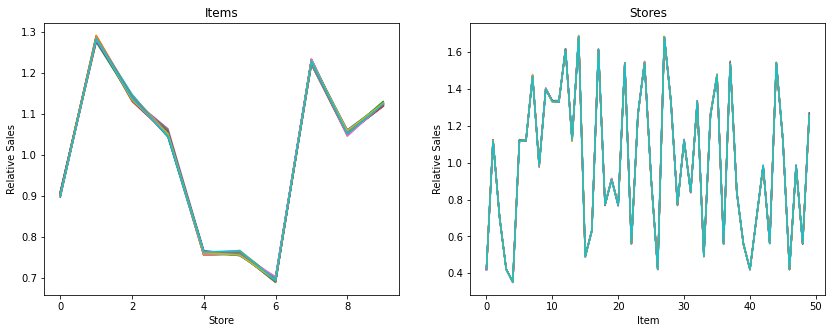

In [101]:
dfAggStoreItem = pd.pivot_table(df_train, index='store', columns='item', values='sales', aggfunc=np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(dfAggStoreItem / dfAggStoreItem.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(dfAggStoreItem.T / dfAggStoreItem.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()

Mesmo aqui. Apenas um padrão constante e sem degenerações. Então, você só precisa de um modelo de como os itens são vendidos em diferentes lojas, o que é facilmente capturado por uma tabela de pesquisa de vendas médias ou ainda outro modelo de padrão de "vendas relativas".

> Nota: Com base na extrema regularidade dos dados, quão limpos e quão poucas degenerações existem - estou bastante confiante de que provavelmente são dados simulados.

##### 2.5) Visualização por Time Series

Agora que fizemos uma análise para ter uma visão geral sobre o conjunto de dados, além disso, fizemos análises das variações de vendas por lojas e por produtos. Vamos fazer uma análise por Time Series para extrair outras informações.

In [102]:
def timeSerie(x, y, xaxis = 'x', yaxis = 'y', title = 'default'):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x,
        y=y
    ))

    fig.update_layout(
            title='<span>{}</span>'.format(title), 
            autosize=False,
            width=1300,
            height=400,
            xaxis=dict(title='<span>{}</span>'.format(xaxis)),
            yaxis=dict(title='<span>{}</span>'.format(yaxis))
        )

    fig.show()
    #return fig

In [103]:
df_week = df_train.copy()
df_week = pd.DataFrame(df_week.groupby(['date', 'store']).sum()['sales']).unstack()
df_week.index = pd.to_datetime(df_week.index)
df_week = df_week.resample('7D', label='left').sum()

In [104]:
df_week.head()

sales                                                            
store         1      2      3      4     5     6     7      8      9      10
date                                                                        
2013-01-01  9461  13209  11658  10918  7704  8025  7028  12684  10633  11516
2013-01-08  9325  13459  11959  10859  7898  7897  7316  12663  10869  11634
2013-01-15  9266  13306  11633  10778  7865  7851  7104  12754  10798  11558
2013-01-22  9247  13286  11871  10729  7782  7950  7271  12726  10957  11618
2013-01-29  9967  14210  12567  11743  8333  8453  7536  13402  11518  12448

In [105]:
fig = go.Figure()

for i in range(df_week.shape[1]):
    fig.add_trace(go.Scatter(
        x=df_week.index,
        y=df_week[('sales',  i + 1)],
        name='Loja ' + str(i + 1)
    ))

fig.update_layout(
    title='<span>Vendas totais de produtos por semana ao longo do tempo</span>', 
    autosize=False,
    width=1250,
    height=400,
    xaxis=dict(title='<span>Período</span>'),
    yaxis=dict(title='<span>Quantidade de vendas</span>')
)
fig.show()


In [106]:
df_date = df_train.copy()
df_date = df_date.groupby('date')['date', 'sales'].sum()

timeSerie(df_date.index, df_date['sales'], 'Período', 'Quantidade de vendas', 'Vendas totais de produtos por dia ao longo do tempo')


In [107]:
df_decomposicao = seasonal_decompose(df_date[['sales']], period=50, extrapolate_trend=50)
timeSerie(df_decomposicao.trend.index, df_decomposicao.trend.values, 'Período', 'Quantidade de vendas', 'Linha de tendência')
timeSerie(df_decomposicao.seasonal.index, df_decomposicao.seasonal.values, 'Período', 'Quantidade de vendas', 'Gráfico de sazonalidade')
timeSerie(df_decomposicao.resid.index, df_decomposicao.resid.values, 'Período', 'Quantidade de vendas', 'Gráfico de resíduos')

In [108]:
Fuller(df_date[['sales']])

ADF Statistic: -3.060244
p-value: 0.029639
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


### 3) Modelagem

##### 3.1) Construindo nosso primeiro modelo (Linear x Quadrático)

Precisamos apenas de uma tabela de consulta de venda média de loja de itens e, em seguida, os modelos "dia da semana", "mensal", "anual".

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,19.971522,53.148959,33.208105,19.956188,16.612815,53.060789,52.783680,69.472070,46.504929,66.354326,...,20.002738,33.105696,46.242607,26.594195,72.720701,52.845016,19.814348,46.546002,26.461665,59.342826
2,28.173604,75.316539,46.992333,28.234940,23.540526,74.945235,75.058598,99.090361,65.478094,94.097481,...,28.069551,47.368018,65.785323,37.785871,103.381161,75.219606,28.187842,66.028478,37.711939,84.622125
3,25.070099,66.804491,41.771084,25.116101,20.857612,67.007119,66.647864,87.517525,58.486857,83.387733,...,24.989047,41.797371,58.197700,33.386090,91.851041,66.748083,25.120482,58.700986,33.259584,74.958379
4,22.938664,61.715225,38.548193,23.086528,19.525192,61.270537,61.625411,80.819825,54.043812,77.047645,...,23.168127,38.539978,54.018620,30.952355,84.687295,61.420044,23.114458,53.765608,30.840635,68.921687
5,16.739321,44.488499,27.835706,16.776561,14.086528,44.564622,44.535597,58.565717,38.837349,55.509858,...,16.830778,27.730559,39.163198,22.415115,61.427163,44.734940,16.699343,39.281490,22.371851,50.319277
6,16.717963,44.533954,27.811062,16.754107,13.893209,44.503834,44.599124,58.385542,39.460022,55.565170,...,16.607338,27.893209,39.034502,22.322563,61.142935,44.539978,16.708653,39.052574,22.181271,50.516429
7,15.159365,40.717963,25.531216,15.358160,12.733844,40.703724,40.709748,53.723987,35.901972,51.156627,...,15.471522,25.435926,35.426068,20.446331,55.905805,40.828587,15.479189,35.624315,20.406353,45.823658
8,26.983571,71.656627,45.076123,26.948521,22.427711,71.958379,71.730559,94.461117,63.193319,89.818182,...,27.036145,45.144031,62.980285,36.194414,98.941402,72.004929,27.150055,62.737130,36.035049,80.972070
9,23.325849,61.792442,38.535049,23.150055,19.272180,61.412377,61.812158,81.287514,54.105696,77.105148,...,23.191128,38.643483,54.152793,30.968237,85.093647,62.010953,23.003286,53.976999,31.052574,69.308324


P1: 2018 Relative Sales by Degree-1 (Linear) Fit = 1.2132
P2: 2018 Relative Sales by Degree-2 (Quadratic) Fit = 1.1509


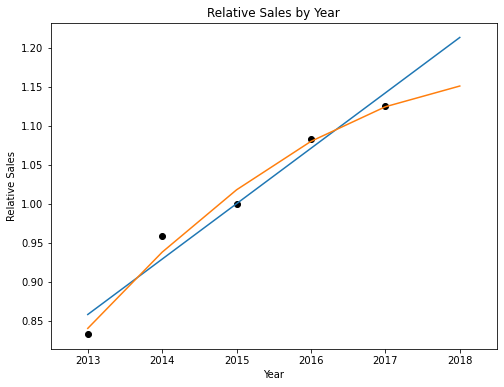

In [109]:
# Item-Store Look Up Table
dfStoreItemTable = pd.pivot_table(df_train, index='store', columns='item', values='sales', aggfunc=np.mean)
display(dfStoreItemTable)

# Monthly pattern
grandAvg = df_train['sales'].mean()
dfMonthTable = pd.pivot_table(df_train, index='month', values='sales', aggfunc=np.mean)
dfMonthTable['sales'] /= grandAvg

# Day of week pattern
dfDowTable = pd.pivot_table(df_train, index='dayofweek', values='sales', aggfunc=np.mean)
dfDowTable.sales /= grandAvg

# Yearly growth pattern
dfYearTable = pd.pivot_table(df_train, index='year', values='sales', aggfunc=np.mean)
dfYearTable /= grandAvg

years = np.arange(2013, 2019)
annualSalesAvg = dfYearTable.values.squeeze()

p1 = np.poly1d(np.polyfit(years[:-1], annualSalesAvg, 1))
p2 = np.poly1d(np.polyfit(years[:-1], annualSalesAvg, 2))

print(f"P1: 2018 Relative Sales by Degree-1 (Linear) Fit = {p1(2018):.4f}")
print(f"P2: 2018 Relative Sales by Degree-2 (Quadratic) Fit = {p2(2018):.4f}")

# We pick the quadratic fit
annualGrowth = p2

plt.figure(figsize=(8,6))
plt.plot(years[:-1], annualSalesAvg, 'ko')
plt.plot(years, p1(years), 'C0-')
plt.plot(years, p2(years), 'C1-')
plt.xlim(2012.5, 2018.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.show()

Podemos fazer uma regressão linear simples nos pontos de dados de crescimento anual. Mas se você olhar com cuidado, pode dizer que o crescimento está desacelerando. O ajuste quadrático funciona melhor, pois captura melhor a curvatura na curva de crescimento. Como temos apenas 5 pontos, este é o ajuste polinomial de grau mais alto que você deve fazer para evitar o overfitting.

Agora, escrevemos o preditor. É bem simples! Quando somos solicitados a prever as vendas do Item X na Loja Y em, digamos, uma segunda-feira de fevereiro - tudo o que precisamos fazer é procurar a média histórica das vendas do Item X na Loja Y e depois multiplicá-la por um fator correspondente a segunda-feira e, em seguida, um fator correspondente a fevereiro para contabilizar as mudanças sazonais e semanais nas vendas de itens nas lojas. Por fim, multiplicamos pelo fator de crescimento anual para o ano para o qual estamos prevendo. E assim, temos uma previsão muito simples das vendas do item.

In [110]:
#df_week.index, pd.to_datetime(x_test['date']).values
def exibeErroEPrevisoes(df):
    def adjusted_r2(y_test, y_pred,X_train):
        adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) / (len(y_test) - X_train.shape[1] - 1))
        return adj_r2

    print('R²: {}'.format(r2_score(df['sales'], df['pred'])))
    print('Adjusted R²: {}'.format(adjusted_r2(df['sales'], df['pred'], df)))
    print('MSE: {}'.format(mean_squared_error(df['sales'], df['pred'])))
    print('MSE: {}'.format(mean_squared_error(df['sales'], df['pred']) ** 0.5))
    print('MAE: {}'.format(mean_absolute_error(df['sales'], df['pred']) ** 0.5))
    print('MAPE: {}'.format(np.mean(np.abs((df['sales'] - df['pred']) / df['sales'])) * 100))
    print('RMSLE: {}'.format(mean_squared_log_error(df['sales'], df['pred'])))

    #Referência sobre métricas de avaliação.
    #https://medium.com/turing-talks/como-avaliar-seu-modelo-de-regressão-c2c8d73dab96

    temp = df.groupby('date')['date', 'pred', 'sales'].sum()
    x = temp.index
    y1 = temp['sales']
    y2 = temp['pred']

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=x,
        y=y1,
        name='Vendas no período'
    ))

    fig.add_trace(go.Scatter(
        x=x,
        y=y2,
        name='Valores previstos'
    ))

    fig.update_layout(
        title='<span>Valores Reais x Previsões</span>', 
        autosize=False,
        width=1250,
        height=400,
        xaxis=dict(title='<span>Período</span>'),
        yaxis=dict(title='<span>Valores previstos</span>')
    )
    fig.show()

In [111]:
x_train = df_train.loc[df_train['date'] < pd.to_datetime('October 3, 2017')]
y_train = df_train.loc[df_train['date'] < pd.to_datetime('October 3, 2017'), 'sales']
x_test = df_train.loc[df_train['date'] >= pd.to_datetime('October 3, 2017')]
y_test = df_train.loc[df_train['date'] >= pd.to_datetime('October 3, 2017'), 'sales']

In [112]:
def relativeGrowth(test, annualGrowth):
    #submission[['sales']] = submission[['sales']].astype(np.float64)
    lstPreds = []
    for _, row in test.iterrows():
        dow, month, year = row['dayofweek'], row['month'], row['year']
        item, store = row['item'], row['store']
        base_sales = dfStoreItemTable.at[store, item]
        mul = dfMonthTable.at[month, 'sales'] * dfDowTable.at[dow, 'sales']
        pred_sales = base_sales * mul * annualGrowth(year)
        
        lstPreds.append(int(round(pred_sales)))
        #submission.at[row['id'], 'sales'] = pred_sales
    x_test['pred'] = lstPreds
    return x_test

#dfSampleSub = pd.read_csv("data/sample_submission.csv")
x_test = relativeGrowth(df_test, annualGrowth)

#dfSlightlyBetterPred['sales'] = round(dfSlightlyBetterPred['sales']).astype(int)

In [113]:
x_test[['sales', 'pred']].head(5)

,sales,pred
1736,18,12
1737,15,14
1738,20,14
1739,19,15
1740,22,16


In [114]:
exibeErroEPrevisoes(x_test)

R²: 0.4925938801011077
Adjusted R²: 0.4924923763207324
MSE: 410.6196888888889
MSE: 20.26375308004144
MAE: 3.9876141571955865
MAPE: 30.057260336444475
RMSLE: 0.13270513592012298


**Como podemos melhorar nosso modelo?**<br/>
Um dos pequenos ajustes que podemos fazer no modelo é pesar os dados por recência. Assim, pesamos menos os dados mais antigos e muito mais os dados recentes! Uma maneira fácil de fazer isso é usar uma função de decaimento exponencial para o seu peso. Queremos que os pesos fiquem exponencialmente menores quanto mais voltamos no passado.

Como se trata de dados simulados, se a simulação tivesse algumas variáveis ocultas que mudaram com o tempo, talvez essa seja uma maneira simples de codificar isso no modelo sem saber o que é.

Aqui eu uso a seguinte equação para os pesos:

<img src="assets/formula.png">

O fator de 5 é escolhido arbitrariamente para dados simulados. Em dados reais, pode fazer sentido, pois você esperaria que as vendas da loja perdessem o poder de previsão após uma década ou mais.

In [115]:
years = np.arange(2013, 2019)
annualSalesAvg = dfYearTable.values.squeeze()

weights = np.exp((years - 2018)/5)

annualGrowth = np.poly1d(np.polyfit(years[:-1], annualSalesAvg, 2, w=weights[:-1]))
print(f"2018 Relative Sales by Weighted Fit = {annualGrowth(2018)}")
x_test = relativeGrowth(df_test, annualGrowth)

2018 Relative Sales by Weighted Fit = 1.1575778494297992


In [116]:
exibeErroEPrevisoes(x_test)

R²: 0.4975549739541347
Adjusted R²: 0.4974544626130719
MSE: 406.6049111111111
MSE: 20.16444670976893
MAE: 3.9812142201427276
MAPE: 30.03732576564521
RMSLE: 0.13099564936077


##### 3.1) Models ARIMA (Dados semanais agrupados)

Será utilizado o quartil de 10% de vendas de itens semanais que foi criado durante a análise exploratória. Como a concorrência está prevendo os próximos 3 meses de vendas, usaremos 3 meses (13 semanas) de dados de teste.

Construiremos um modelo ARIMA para cada quartil e usaremos agrupamento e porcentagens para chegar às vendas diárias de itens por loja.

In [117]:
trainWeek = df_week[:-13]
testWeek = df_week.loc[df_week.index >= pd.to_datetime('October 3, 2017')]

In [118]:
trainWeek.shape, testWeek.shape

((248, 10), (13, 10))

Fitting Models and Forecasting

In [119]:
dfPredictionsSARIMAX = pd.DataFrame()

for column in trainWeek:
    print('Treinando coluna: {}'.format(column))
    _dfTemp = pd.DataFrame(list(trainWeek[column]), index=trainWeek.index, columns=['sales'])

    model = sm.tsa.statespace.SARIMAX(_dfTemp['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

    model_fit = model.fit()

    startIndex = trainWeek.shape[0]
    endIndex = trainWeek.shape[0] + testWeek.shape[0]
    dfPredictionsSARIMAX[column[1]] = model_fit.predict(start=startIndex, end=endIndex, dynamic=True)

Treinando coluna: ('sales', 1)
Treinando coluna: ('sales', 2)
Treinando coluna: ('sales', 3)
Treinando coluna: ('sales', 4)
Treinando coluna: ('sales', 5)
Treinando coluna: ('sales', 6)
Treinando coluna: ('sales', 7)
Treinando coluna: ('sales', 8)
Treinando coluna: ('sales', 9)
Treinando coluna: ('sales', 10)


In [120]:
temp = pd.DataFrame()
lstValues = []
lstIndex = []
lstStore = []
for i in range(dfPredictionsSARIMAX.shape[0]):
    for coluna in dfPredictionsSARIMAX:
        lstIndex.append(dfPredictionsSARIMAX.index[i])
        lstValues.append(dfPredictionsSARIMAX[[coluna]].iloc[i].values[0])
        lstStore.append(coluna)
    

temp['date'] = lstIndex
temp['store'] = lstStore
temp['value'] = lstValues

In [121]:
lstRows = []
for i in range(temp.shape[0]):
    _row = df_item_store.loc[df_item_store.index == temp['store'][i]]
    
    lstColumns = []
    lstColumns.append(temp['date'][i])
    lstColumns.append(temp['store'][i])
    lstColumns.append(temp['value'][i])

    for coluna in _row:
        lstColumns.append(round((_row[coluna].values[0] / 100) * temp['value'][i]))
        #temp[coluna] = _row[coluna].values[0]
        #temp[coluna].apply(lambda x: (x / 100) * temp['value'][i])

    lstRows.append(lstColumns)

lstNameColumns = [i for i in range(1, 51)]
lstNameColumns.insert(0, 'value')
lstNameColumns.insert(0, 'store')
lstNameColumns.insert(0, 'date')

x_testArima = pd.DataFrame(lstRows, columns=lstNameColumns)

In [122]:
x_testArima.head(15)

,date,store,value,1,2,3,4,5,6,7,...,41,42,43,44,45,46,47,48,49,50
0,2017-10-03,1,18729.946821,158,421,263,158,132,421,418,...,159,262,366,211,576,419,157,369,210,470
1,2017-10-03,2,27177.854368,228,611,381,229,191,608,609,...,228,384,533,306,838,610,229,535,306,686
2,2017-10-03,3,23734.736612,200,533,333,200,166,534,531,...,199,333,464,266,732,532,200,468,265,598
3,2017-10-03,4,22415.364631,187,504,315,189,159,500,503,...,189,315,441,253,692,502,189,439,252,563
4,2017-10-03,5,15909.981694,134,356,223,134,113,357,356,...,135,222,313,179,491,358,134,314,179,403
5,2017-10-03,6,16277.294133,137,365,228,137,114,365,365,...,136,229,320,183,501,365,137,320,182,414
6,2017-10-03,7,14696.487671,123,329,206,124,103,329,329,...,125,206,286,165,452,330,125,288,165,370
7,2017-10-03,8,25679.972442,216,574,361,216,180,576,574,...,216,361,504,290,792,577,217,502,289,648
8,2017-10-03,9,22314.898887,189,501,312,188,156,498,501,...,188,313,439,251,690,503,186,438,252,562
9,2017-10-03,10,23619.373165,199,528,331,199,166,528,530,...,198,332,466,265,730,531,199,465,266,596


In [123]:
dfPredSales = x_testArima.drop(columns=['date', 'store', 'value'])
lstTotal = []

for i in range(dfPredSales.shape[0]):
    store = x_testArima.iloc[i]['store']

    for column in dfPredSales:
        date = x_testArima.iloc[i]['date']
        for day in df_dow_item:
            pred = round((df_dow_item.iloc[column - 1][day] / 100) * dfPredSales.iloc[i][column])
            lstTotal.append([date, store, column, pred])
            date += pd.DateOffset(days=1)

dfPredSales = pd.DataFrame(lstTotal, columns=['date', 'store', 'item', 'pred']).sort_values(by=['store', 'item', 'date'])

In [124]:
x_testWeek = x_test.copy()
dfPredSales = dfPredSales.loc[dfPredSales['date'] <= x_testWeek['date'].max()]
dfPredSales.index = x_testWeek.index

x_testWeek['pred'] = dfPredSales['pred']
x_testWeek.head(10)

,date,store,item,sales,day,month,year,dayofweek,pred
1736,2017-10-03,1,1,18,3,10,2017,1,18
1737,2017-10-04,1,1,15,4,10,2017,2,21
1738,2017-10-05,1,1,20,5,10,2017,3,21
1739,2017-10-06,1,1,19,6,10,2017,4,22
1740,2017-10-07,1,1,22,7,10,2017,5,24
1741,2017-10-08,1,1,19,8,10,2017,6,25
1742,2017-10-09,1,1,9,9,10,2017,0,27
1743,2017-10-10,1,1,23,10,10,2017,1,18
1744,2017-10-11,1,1,14,11,10,2017,2,21
1745,2017-10-12,1,1,24,12,10,2017,3,21


In [125]:
exibeErroEPrevisoes(x_testWeek)

R²: -0.9233284751066195
Adjusted R²: -0.9237132263019066
MSE: 1556.4584444444445
MSE: 39.451976432676275
MAE: 5.622119015302168
MAPE: 82.9746336654681
RMSLE: 0.5230624647840626


**Precisão do modelo**<br/>
As previsões foram organizadas da mesma forma que os dados de teste, para que possamos simplesmente conectar ambos à nossa função de erro.

##### 3.2) Models ARIMA (Dados semanais não agrupados)

Aqui vou deixar o código para realizar o treinamento e a previsão sem realizar qualquer tipo de agrupamento nos dados. Infelizmente realizar o treinamento dessa forma é inviável para a capacidade computacional da minha máquina, mas de qualquer forma aqui está o código. <br/>

Será que vai melhorar o modelo? Acho que não, pois embora o modelo ARIMA tenha tido uma boa precisão, vimos que pelas métricas o modelo não foi capaz de aprender a relação entre os dados e obteve resultados péssimos. E o que isto implica?<br/>

Implica que a medida que formos avançando no tempo, as previsões tendem se tornar cada vez mais imprecisas.

<blockquote>
x_train = df_train.loc[df_train['date'] < pd.to_datetime('October 3, 2017')]<br/>
y_train = df_train.loc[df_train['date'] < pd.to_datetime('October 3, 2017'), 'sales']<br/>
x_test = df_train.loc[df_train['date'] >= pd.to_datetime('October 3, 2017')]<br/>
y_test = df_train.loc[df_train['date'] >= pd.to_datetime('October 3, 2017'), 'sales']<br/>


dfPredictionsSARIMAX = pd.DataFrame()<br/>

for column in x_train:<br/>
&emsp;    print('Treinando coluna: {}'.format(column))
&emsp;    _dfTemp = pd.DataFrame(list(x_train[column]), index=x_train.index, columns=['sales'])

&emsp;    model = sm.tsa.statespace.SARIMAX(_dfTemp['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

&emsp;    model_fit = model.fit()

&emsp;    startIndex = x_train.shape[0]
&emsp;    endIndex = x_train.shape[0] + x_test.shape[0]
&emsp;    dfPredictionsSARIMAX[column[1]] = model_fit.predict(start=startIndex, end=endIndex, dynamic=True)

</blockquote>

##### 3.3) XGB Regressor (Extreme Boosting Gradient Regressor)

In [126]:
x_train = df_train.loc[df_train['date'] < pd.to_datetime('October 3, 2017'), ['store', 'item', 'day', 'month', 'year']]
y_train = df_train.loc[df_train['date'] < pd.to_datetime('October 3, 2017'), 'sales'].values
x_test = df_train.loc[df_train['date'] >= pd.to_datetime('October 3, 2017'), ['store', 'item', 'day', 'month', 'year']]
y_test = df_train.loc[df_train['date'] >= pd.to_datetime('October 3, 2017'), 'sales'].values

In [127]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], early_stopping_rounds=50, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

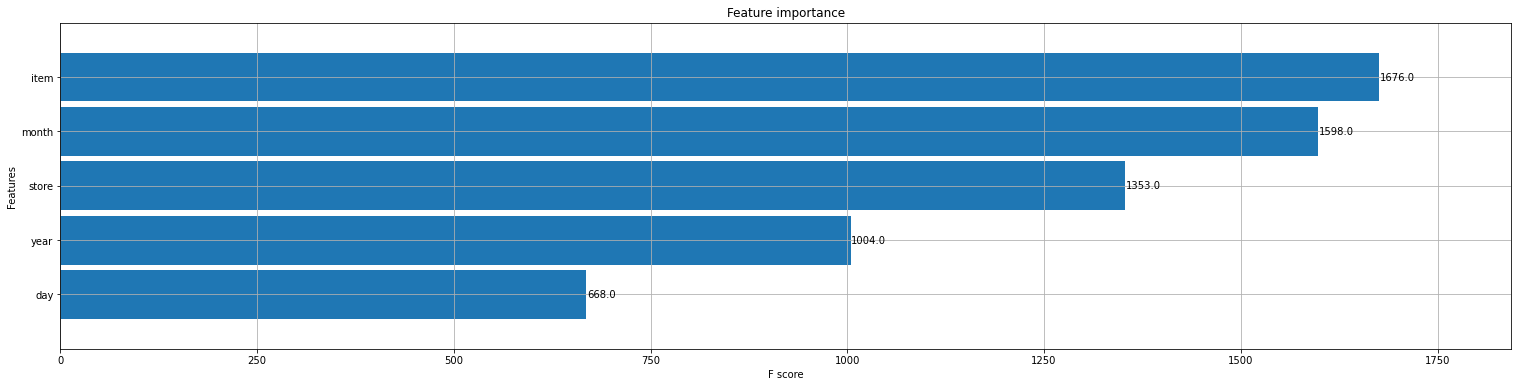

In [128]:
_ = plot_importance(reg, height=0.9)

In [129]:
preds = reg.predict(x_test)
x_test['pred'] = np.round(preds)
x_test['sales'] = y_test
x_test['date'] = df_train.loc[df_train['date'] >= pd.to_datetime('October 3, 2017'), 'date']
x_test.head()


,store,item,day,month,year,pred,sales,date
1736,1,1,3,10,2017,20.0,18,2017-10-03
1737,1,1,4,10,2017,21.0,15,2017-10-04
1738,1,1,5,10,2017,20.0,20,2017-10-05
1739,1,1,6,10,2017,20.0,19,2017-10-06
1740,1,1,7,10,2017,20.0,22,2017-10-07


In [130]:
exibeErroEPrevisoes(x_test)

R²: 0.8441217528713869
Adjusted R²: 0.8440940356395621
MSE: 126.14486666666667
MSE: 11.23142318082026
MAE: 2.9317154629253426
MAPE: 18.62283467183422
RMSLE: 0.048622387532140696


##### 3.3) Tensorflow

In [197]:
x_train = df_train.loc[df_train['date'] < pd.to_datetime('October 3, 2017'), ['store', 'item', 'date', 'sales']]
y_train = df_train.loc[df_train['date'] < pd.to_datetime('October 3, 2017'), 'sales'].values
x_test = df_train.loc[df_train['date'] >= pd.to_datetime('October 3, 2017'), ['store', 'item', 'date']]
y_test = df_train.loc[df_train['date'] >= pd.to_datetime('October 3, 2017'), 'sales'].values

In [198]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [199]:
lag_size = 1
window = 5
series = series_to_supervised(x_train.drop('date', axis=1), window=window, lag=lag_size)
series.head()

,store(t-5),item(t-5),sales(t-5),store(t-4),item(t-4),sales(t-4),store(t-3),item(t-3),sales(t-3),store(t-2),...,sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+1),item(t+1),sales(t+1)
5,1.0,1.0,13.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,13.0,1.0,1.0,10.0,1,1,12,1.0,1.0,10.0
6,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,...,10.0,1.0,1.0,12.0,1,1,10,1.0,1.0,9.0
7,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,...,12.0,1.0,1.0,10.0,1,1,9,1.0,1.0,12.0
8,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,...,10.0,1.0,1.0,9.0,1,1,12,1.0,1.0,9.0
9,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,...,9.0,1.0,1.0,12.0,1,1,9,1.0,1.0,9.0


In [200]:
series.shape

(867994, 21)

In [201]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [202]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [203]:
labels

5          10.0
6          12.0
7          10.0
8           9.0
9          12.0
          ...  
912904     79.0
912905     80.0
912906     82.0
912907     90.0
912908    103.0
Name: sales(t-1), Length: 865499, dtype: float64

In [204]:
# Label
labels_col = 'sales(t-%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (519299, 6)
Validation set shape (346200, 6)


,sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t),sales(t+1)
462332,31.0,32.0,19.0,28.0,38,35.0
494912,91.0,64.0,73.0,82.0,83,86.0
613980,18.0,16.0,12.0,15.0,18,25.0
748854,31.0,33.0,31.0,28.0,47,35.0
904134,44.0,39.0,53.0,40.0,65,49.0


In [205]:
import tensorflow as tf

In [206]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (519299, 6, 1)
Validation set shape (346200, 6, 1)


In [207]:
epochs = 40
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

In [208]:
model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [209]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
16229/16229 - 537s - loss: 121.7093 - val_loss: 114.6252 - 537s/epoch - 33ms/step
Epoch 2/40


KeyboardInterrupt: 